Load libraries.

In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(lme4)
library(ez)
library(repr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Matrix



This is a general run-through of what the lay out of the results for this manuscript will look like. I'll try to intersperse the overarching story as I go.

# Results

We're trying to test the general hypothesis that --- consistent with the EVC theory --- people will be sensitive to both the magnitude and direction of reward difference between tasks.  

Hypotheses:  

1. Experiment 1 --- Switch rates will increase linearly as a function of the magnitude of the difference between task rewards.
2. Experiment 2 ---  Switch rates will increase more dramatically in response to changes in difference and color than in response to difference alone

I also introduced the idea that we'll include post-hoc analyses that investigate other possible factors that drive task selection.
*  Most notably, the idea that sudden increases in reward lead to increased flexibility, which lead to more switching.

This notebook also includes some exploratory poking around, most of which didn't make it to the manuscript.

## Experiment 1

We expected that, when there is no added incentive to switch, participants will invariably repeat tasks. We can look at switch rates in contexts where there is no incentive to switch (i.e., difference <= 0) to investigate the prediction that switch rates will be near zero.

In [2]:
current_data <- fread('../data/disconnect.csv')
head(current_data)

subject,block,leftpoints,rightpoints,responselocation,rsi,rt,blocktime,transcode,stimrep,current_pv,other_pv,difference,subject_error,rt_mean,rt_sd
1,1,6,3,left,1100,2737,182.62,0,0,6,3,-3,0.02258469,1067.247,871.0008
1,1,8,10,right,200,1443,182.62,1,1,8,10,2,0.02258469,1067.247,871.0008
1,1,4,10,right,200,826,182.62,0,1,10,4,-6,0.02258469,1067.247,871.0008
1,1,10,1,left,1100,597,182.62,1,1,1,10,9,0.02258469,1067.247,871.0008
1,1,6,10,right,200,1127,182.62,1,0,6,10,4,0.02258469,1067.247,871.0008
1,1,3,4,right,200,859,182.62,0,0,4,3,-1,0.02258469,1067.247,871.0008


Let's take a look at the observed switch rates across the point difference first.

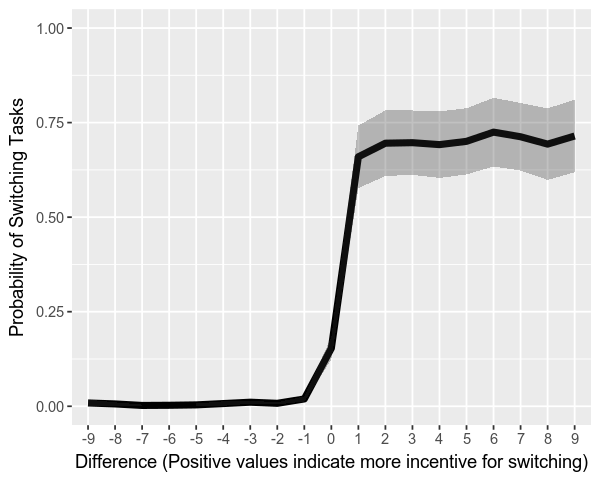

In [3]:
options(repr.plot.width = 5, repr.plot.height = 4)

## keep a subject means dataset in memory
subject_means <- current_data  %>% 
group_by(subject, difference)  %>% 
summarize(transcode = mean(transcode))

subject_means %>% 
group_by(difference) %>% 
summarize(switch = mean(transcode), se = sd(transcode) / sqrt(n())) %>% 
ggplot(aes(x = factor(difference), y = switch, group = 1)) + geom_line(size = 2) + 
geom_ribbon(aes(ymin = switch - se, ymax = switch + se), alpha = .3) + ylim(0,1) + 
xlab('Difference (Positive values indicate more incentive for switching)') + ylab('Probability of Switching Tasks')

It's qualitatively obvious that out inital prediction--that switch rates would be near zero when there is no incentive to switch--is bourne out by the data. Let's take a closer look at the descriptive trends by looking at individual subject data. I think it makes sense to refer the reader to the figure above in the first paragraph of the "Task Selection" section in the results.

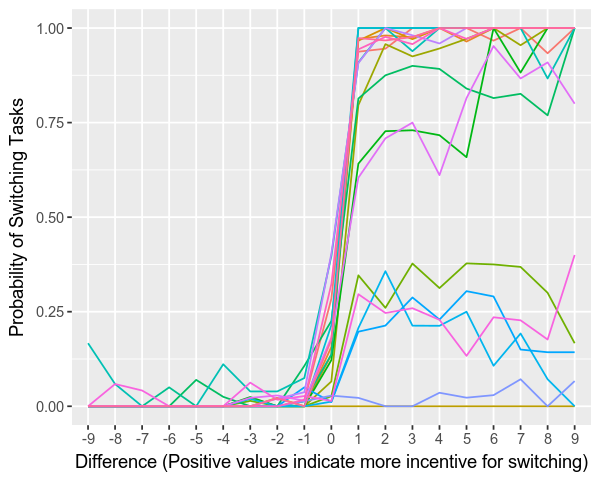

In [4]:
subject_means %>% 
ggplot(aes(x = factor(difference), y = transcode, group = factor(subject))) + 
geom_line(aes(color = factor(subject))) + theme(legend.position = 'none') + 
xlab('Difference (Positive values indicate more incentive for switching)') + ylab('Probability of Switching Tasks')

## Showing that we're not interested in contexts where there's no incentive for switching

We said in the intro that we expected switch rates to invariabily be near zero when there was no added incentive for switching. This is qualitately obvious from the observed means, but let's try to capture that statistically.  
*Dealing with only switch rates at difference <= 0 for now*  
The variablility across subjects looks quite low when the difference < 0.  
It looks like there's more variablity *at* difference == 0, let's explore that.

[1] "Mean: 0.15 Max: 0.4 Min: 0"

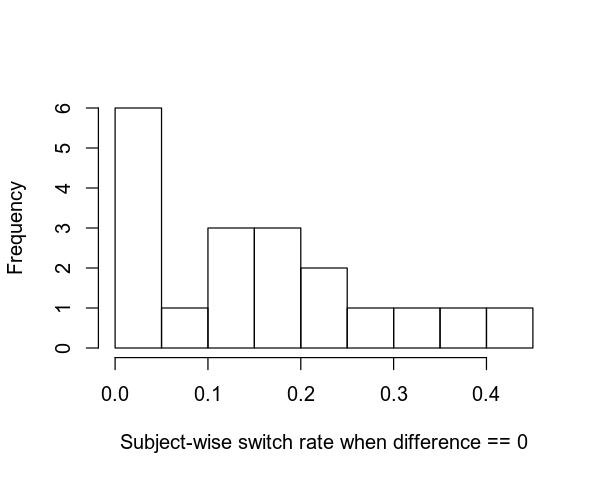

In [5]:
subject_means <- as.data.table(subject_means)
hist(subject_means[difference == 0, 'transcode']$transcode, main = '', xlab = 'Subject-wise switch rate when difference == 0')
paste('Mean: ', round(subject_means[difference == 0, mean(transcode)], 2), 
      ' Max: ', round(subject_means[difference == 0, max(transcode)], 2),
     ' Min: ', round(subject_means[difference == 0, min(transcode)], 2), sep = '')

We're seeing more variability in switch rates at the difference == 0 level, but the average switch rate is only .15, with the max being .4. If task selections were purely driven by considerations of reward, then when the tasks have the same amount of reward, there should be no preferance for one over the other (i.e., switch rate of 50%). But what we're seeing is way below that, and in fact I'll do a one-sample t-test to illustrate this.

In [6]:
subject_means <- as.data.table(subject_means)
subject_means[difference == 0, .(transcode = mean(transcode), se = sd(transcode) / sqrt(.N))]

t.test(subject_means[difference == 0]$transcode, mu = .5)

transcode,se
0.1534004,0.02971271



	One Sample t-test

data:  subject_means[difference == 0]$transcode
t = -11.665, df = 18, p-value = 7.949e-10
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.09097633 0.21582452
sample estimates:
mean of x 
0.1534004 


Now we can officially see that the distribution of switch rates at difference == 0 is significantly lower than 50% (*t*(18) = 11.67, *p* < .001).

Switch rates at difference == 0 are slightly higher than at negative levels of the difference, but we can show *this* statistically too.

In [7]:
subject_means %>% 
mutate(diff_code = factor(ifelse(difference == 0, 'zero', ifelse(difference < 0, 'negative','')))) %>% 
group_by(diff_code) %>% 
summarize(switch = mean(transcode), se = sd(transcode) / sqrt(n())) %>% 
data.table()

diff_code,switch,se
,0.698815589,0.029007137
negative,0.007619182,0.001670011
zero,0.153400423,0.029712712


In [8]:
t.test(subject_means[difference == 0]$transcode, 
       subject_means[difference < 0, .(transcode = mean(transcode)), by = subject]$transcode, paired = TRUE)


	Paired t-test

data:  subject_means[difference == 0]$transcode and subject_means[difference < 0, .(transcode = mean(transcode)), subject_means[difference == 0]$transcode and     by = subject]$transcode
t = 5.1049, df = 18, p-value = 7.403e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.08578474 0.20577774
sample estimates:
mean of the differences 
              0.1457812 


When the difference is negative: *M* = .008, *SE* = .002  
When the difference is zero: *M* = .15, *SE* = .03  
*t*(18) = 5.10, *p* < .001

Even when averaging switch rates at zero on the difference with switch rates at negative differences, switch rates are still very close to zero. Two ways we might be able to capture this intuition statistically would be to:
*  For each subject, collapse switch rates across negative levels (and zero) on the difference and compare to zero with a one-sample t-test.
*  Compare switch rates at and below zero on the difference against switch rates above zero on the difference with a paired t-test.

In [9]:
subject_means <- current_data %>% 
  group_by(subject, difference) %>% 
  summarize(transcode = mean(transcode)) %>% 
  mutate(diff_d = ifelse(difference > 0, 1, 0)) %>% 
  group_by(subject, diff_d) %>% 
  summarize(transcode = mean(transcode)) %>% 
  data.table()

c(mean = subject_means[diff_d == 0, mean(transcode)], se = subject_means[diff_d == 0, sd(transcode) / sqrt(.N)])

t.test(subject_means[diff_d == 0, 'transcode']$transcode, mu = 0)

mean          se 
0.022197306 0.004803423


	One Sample t-test

data:  subject_means[diff_d == 0, "transcode"]$transcode
t = 4.6211, df = 18, p-value = 0.0002122
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.01210569 0.03228892
sample estimates:
 mean of x 
0.02219731 


The mean of switching overall when the difference is <= 0 is .02, and with very little variability (*SE* = .005). However, this is *still* significantly higher than zero (*t*(18) = 4.62, *p* < .001). This might be due to the fact that variability is so low?


Let's run the paired t-test to compare this switching distribution against the one where there is added reward for switching.

In [10]:
subject_means <- current_data %>% 
  group_by(subject, difference) %>% 
  summarize(transcode = mean(transcode)) %>% 
  data.table()

subject_means_a <- subject_means %>% 
  mutate(diff_d = ifelse(difference > 0, 1, 0)) %>% 
  group_by(subject, diff_d) %>% 
  summarize(transcode = mean(transcode)) %>% 
  data.table()

paste('When difference is <= 0, mean = ', round(subject_means_a[diff_d == 0, mean(transcode)], 2), 
      ', se = ', round(subject_means_a[diff_d == 0, sd(transcode) / sqrt(.N)], 2), sep = '')
paste('When difference is > 0, mean = ', round(subject_means_a[diff_d == 1, mean(transcode)], 3), 
      ', se = ', round(subject_means_a[diff_d == 1, sd(transcode) / sqrt(.N)], 2), sep = '')
t.test(subject_means_a[diff_d == 0, 'transcode']$transcode, subject_means_a[diff_d == 1, 'transcode']$transcode, paired = TRUE)

[1] "When difference is <= 0, mean = 0.02, se = 0"

[1] "When difference is > 0, mean = 0.699, se = 0.09"


	Paired t-test

data:  subject_means_a[diff_d == 0, "transcode"]$transcode and subject_means_a[diff_d == 1, "transcode"]$transcode
t = -7.9145, df = 18, p-value = 2.855e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.8562288 -0.4970078
sample estimates:
mean of the differences 
             -0.6766183 


We can see that switch rates when there is added reward for switching, switch rates are significantly higher than when there isn't (*t*(18) = 7.91, *p* < .001). There might be better ways to capture this idea that switch rates are virtually zero when switching isn't rewarded, but this seems sufficient.

## Describing the bimodal switch rates when difference is greater than zero

Joining, by = "subject"


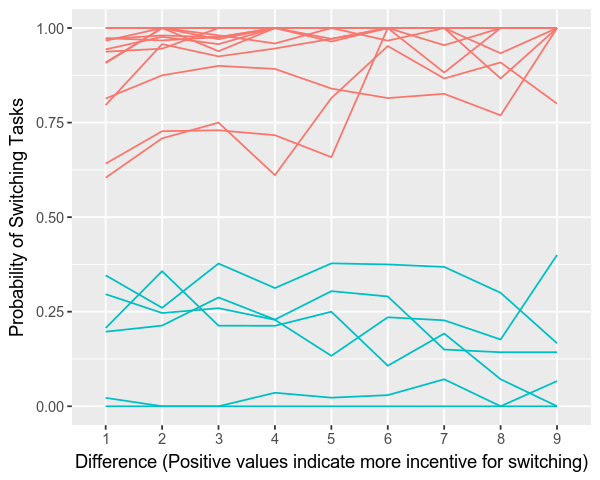

In [11]:
x <- subject_means
subject_means <- x %>% 
filter(difference > 0) %>% 
group_by(subject) %>% 
summarize(subject_code = mean(transcode)) %>% 
inner_join(subject_means) %>% 
mutate(subject_code = factor(ifelse(subject_code >= .5, 'high', 'low'))) %>% 
filter(difference > 0) %>% 
data.table()
subject_means %>% 
ggplot(aes(x = factor(difference), y = transcode, group = subject)) + geom_line(aes(color = subject_code)) + 
theme(legend.position = 'none') + 
xlab('Difference (Positive values indicate more incentive for switching)') + ylab('Probability of Switching Tasks')

In [12]:
subject_means[difference > 0, .(transcode = mean(transcode)), by = subject][, 'subject_code' := ifelse(transcode >= .5, 
                                                                                                       'high','low')][,.(count = .N, switch = mean(transcode), sd = sd(transcode)), by = subject_code]

subject_code,count,switch,sd
high,13,0.9452439,0.07514801
low,6,0.1648877,0.12617378


There is a pretty clear split in switch rates where 13 of the participants are switching frequently when difference > 0, and 6 participants are switching less than 50%.

In [13]:
x <- current_data %>% 
group_by(subject, block) %>% 
summarize(blocktime = mean(blocktime)) %>% 
group_by(subject) %>% 
summarize(blocktime = mean(blocktime)) %>% 
inner_join(subject_means) %>% 
group_by(subject, subject_code) %>% 
summarize(blocktime = mean(blocktime)) %>% 
data.table()

x %>% 
group_by(subject_code) %>% 
summarize(efficiency = mean(blocktime), sd = sd(blocktime))

t.test(x[subject_code == 'high']$blocktime, x[subject_code == 'low']$blocktime, paired = FALSE)

Joining, by = "subject"


subject_code,efficiency,sd
high,108.5409,13.14428
low,121.1888,41.02878



	Welch Two Sample t-test

data:  x[subject_code == "high"]$blocktime and x[subject_code == "low"]$blocktime
t = -0.73783, df = 5.4798, p-value = 0.491
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -55.57744  30.28159
sample estimates:
mean of x mean of y 
 108.5409  121.1888 


Participants who switched more when there was more reward to be gained from switching tended to complete blocks faster than those participants who didn't switch as often in these contexts. This difference isn't significant, but it's likely because we don't have the requisite sample size to be running these sorts of between-subject, inferential analyses, especially because (in this case) the groups self-selected and the "low" group was only *N* = 6 (note the high SE).  

I'm going to jump through some hoops real quick to figure out the power we actually have in the test above (going back to undergrad stats for this one). Calculating a pooled variance with group variances not assumed to be equal (looking [here](https://en.wikipedia.org/wiki/Student%27s_t-test#Equal_or_unequal_sample_sizes.2C_unequal_variances)).

In [14]:
descriptives <- x[, .(blocktime = mean(blocktime), sd = sd(blocktime), N = .N), by = subject_code]
descriptives

subject_code,blocktime,sd,N
high,108.5409,13.14428,13
low,121.1888,41.02878,6


This is a headache. Maybe I'll come back to it if it's necessary.

## Fitting the model

The goal here is to fit a generalized linear mixed model where difference predicts the odds of switching, controlling for random intercept and slope of difference grouped by participants. Since we're only analyzing levels on the difference greater than zero, I'm centering the difference at five so that estimates are generated from the middle of the distribution.

In [15]:
current_data$difference_c <- current_data$difference - 5
model1 <- glmer(transcode ~ difference_c + (1 + difference_c | subject), data = current_data[difference > 0],
               family = binomial(link = 'logit'), control = glmerControl(optimizer = 'bobyqa'), nAGQ = 1)

Let's first compare the fit of the model above with a model without the covariance parameter between the slope of difference and intercept. If the change in log likelihood is significant (according to a likelihood ratio test), we can be confident that the covariance is a significant parameter in the model.

In [16]:
model2 <- glmer(transcode ~ difference_c + (1 | subject) + (0 + difference_c | subject), 
                data = current_data[difference > 0],
               family = binomial(link = 'logit'), 
                control = glmerControl(optimizer = 'bobyqa'), nAGQ = 1)

In [17]:
anova(model1, model2)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
model2,4,3439.211,3466.140,-1715.606,3431.211,NA,NA,NA
model1,5,3430.179,3463.839,-1710.089,3420.179,11.03264,1,0.0008952144


The comparison is highly significant, suggesting model1 fits the data significantly better.  

Now to take a quick look at the residuals from model1 to ensure that they seem normall distributed. Stealing a function from [here](https://stackoverflow.com/questions/4357031/qqnorm-and-qqline-in-ggplot2/) to generate a qqplot.

In [18]:
qqplot.data <- function (vec) # argument: vector of numbers
{
  # following four lines from base R's qqline()
  y <- quantile(vec[!is.na(vec)], c(0.25, 0.75))
  x <- qnorm(c(0.25, 0.75))
  slope <- diff(y)/diff(x)
  int <- y[1L] - slope * x[1L]
  d <- data.frame(resids = vec)
  ggplot(d, aes(sample = resids)) + stat_qq() + geom_abline(slope = slope, intercept = int)
}

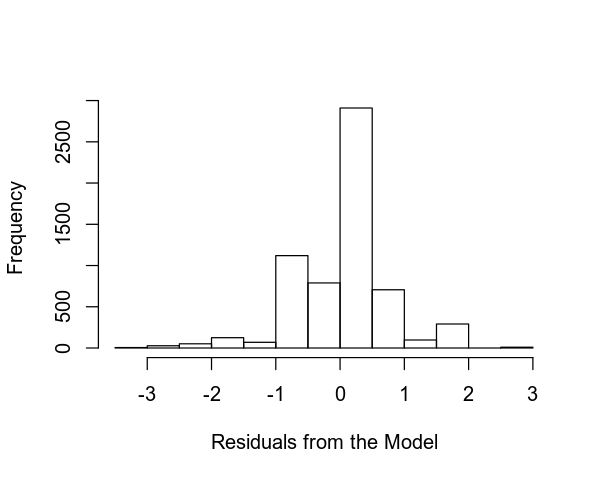

In [19]:
hist(resid(model1), main = '', xlab = 'Residuals from the Model')

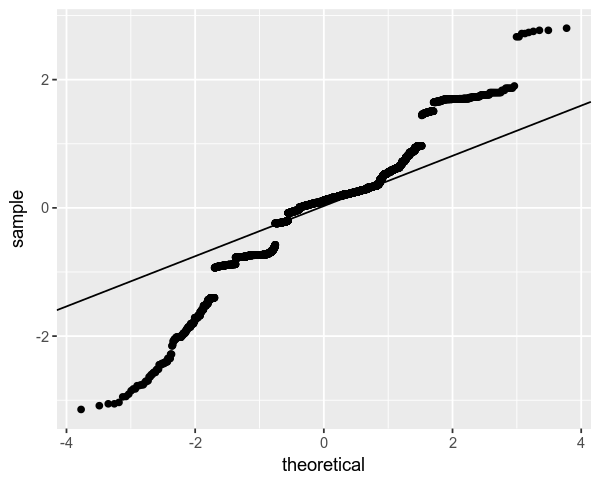

In [20]:
qqplot.data(resid(model1))

And now we'll visualize and interpret the results.

In [21]:
summary(model1)
exp(fixef(model1))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: transcode ~ difference_c + (1 + difference_c | subject)
   Data: current_data[difference > 0]
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  3430.2   3463.8  -1710.1   3420.2     6194 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-11.7961  -0.1672   0.0820   0.2096   7.0513 

Random effects:
 Groups  Name         Variance Std.Dev. Corr
 subject (Intercept)  17.02120 4.1257       
         difference_c  0.06515 0.2552   0.95
Number of obs: 6199, groups:  subject, 19

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)   
(Intercept)    2.2052     0.9594   2.299  0.02153 * 
difference_c   0.2085     0.0711   2.932  0.00337 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
differenc_c 0.842 

(Intercept) difference_c 
    9.072468     1.231802

difference,switch,se
1,0.6596414,0.08270129
2,0.6955359,0.08664549
3,0.6969218,0.08510116
4,0.6917641,0.08809445
5,0.7004569,0.08743199
6,0.7247913,0.09075532
7,0.7125833,0.08930339
8,0.6931094,0.09458165
9,0.7145363,0.09600117


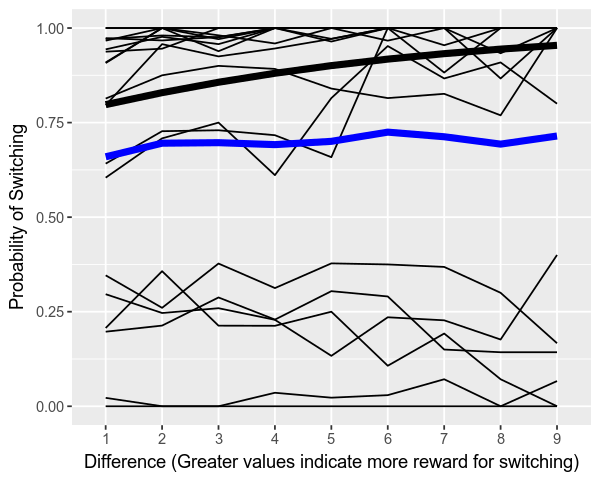

In [22]:
test_data <- data.table(difference_c = -4:4)
intercept <- fixef(model1)[1]
difference_b <- fixef(model1)[2]
test_data$fit <- with(test_data, plogis(intercept + difference_c * difference_b))
test_data$difference <- 1:9

cell_means <- subject_means %>% 
group_by(difference) %>% 
summarize(switch = mean(transcode), se = sd(transcode) / sqrt(n()))
cell_means

ggplot(data = subject_means, aes(x = factor(difference), y = transcode)) + geom_line(aes(group = subject)) + 
geom_line(data = test_data, aes(x = factor(difference), y = fit, group = 1), size = 2) + ylim(0,1) +
geom_line(data = cell_means, aes(x = factor(difference), y = switch, group = 1), size = 2, color = 'blue') + 
#geom_ribbon(data = cell_means, aes(ymin = switch - se, ymax = switch + se), color = 'blue', alpha = .3) + 
xlab('Difference (Greater values indicate more reward for switching)') + 
ylab('Probability of Switching')

The black line is estimates from the model, the blue line is observed means. Each unit increase in the difference is associated with a 1.23 factor increase in the odds of switching tasks (*p* = .003). We can see that the fitted estimates nicely track the subject data that we're interested in explaining, and we're also seeing the same rise in the overall cell means across the difference.